In [1]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
# from keras.datasets import mnist
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras import backend as K
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score
from time import time
from scipy.spatial.distance import euclidean

/Users/tradergllc/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Prepare Reality Mining Data

In [2]:
# Apps By Week
df = pd.read_csv('/Users/tradergllc/rsi/datasets/proc/reality-mining/txt/interim/appsByWeek.txt', 
                 sep=', ', header=None, engine='python', dtype=str, names=['id', 'date', 'app', 'freq'])

In [3]:
# Clean app names
for r in range(len(df.index)):
    if df.iloc[r, 2].find(':') > -1:
        print df.iloc[r]
        df.iloc[r, 2] = 'Phone'

id                                                   11
date                                            2004.44
app     Phone20041027T235032area,cell,nw:5119,40791,TMO
freq                                                  1
Name: 2684, dtype: object
id                                           67
date                                    2004.41
app     Phone??20041009T021013UserActivity:idle
freq                                          1
Name: 15101, dtype: object


In [4]:
df['app'].unique().shape

(200,)

In [5]:
def convert_to_dict(df, col='app'):
    data_dict = {}
    
    unique = list(df[col].unique())
    
    pid = int(df.iloc[0,0])
    date = df.iloc[0, 1]
    data_dict[pid] = {}
    data_dict[pid][date] = np.zeros((len(unique),))
    
    for r in range(1, len(df.index)):
        if int(df.iloc[r, 0]) != pid:
            pid = int(df.iloc[r, 0])
            data_dict[pid] = {}
            date = None
        
        if df.iloc[r, 1] == date:
            try:
                data_dict[pid][date][unique.index(df.iloc[r, 2])] = df.iloc[r, 3]
            except ValueError:
                pass
        else:
            date = df.iloc[r, 1]
            data_dict[pid][date] = np.zeros((len(unique),))
            try:
                data_dict[pid][date][unique.index(df.iloc[r, 2])] = int(df.iloc[r, 3])
            except ValueError:
                pass
    return data_dict, unique

In [6]:
data_dict, unique = convert_to_dict(df)

In [7]:
def dict_to_np_array(d):
    vector_list = []
    gt_pid = []
    for pid in d.keys():
        for date in d[pid].keys():
            vector_list.append(d[pid][date])
            gt_pid.append(d.keys().index(pid))
    return np.stack(vector_list), np.array(gt_pid)

In [8]:
x_train, y_train = dict_to_np_array(data_dict)
print x_train.shape, y_train.shape

(1911, 200) (1911,)


In [9]:
x_train = x_train / (x_train.max(axis=1)[:, None] + 1e-5)

In [10]:
y_train

array([ 0,  0,  0, ..., 87, 87, 87])

### Train VAE

In [11]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [12]:
original_dim = len(unique)

# network parameters
input_shape = (original_dim, )
intermediate_dim = 10
batch_size = 128
latent_dim = 2
# epochs = 50

In [13]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 200)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           2010        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            22          dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            22          dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [14]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_3 (Dense)              (None, 200)               2200      
Total params: 2,230
Trainable params: 2,230
Non-trainable params: 0
_________________________________________________________________


In [15]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [16]:
reconstruction_loss = categorical_crossentropy(inputs,
                                          outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=Adam(lr=0.001, decay=1.0e-6))
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 200)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 2054      
_________________________________________________________________
decoder (Model)              (None, 200)               2230      
Total params: 4,284
Trainable params: 4,284
Non-trainable params: 0
_________________________________________________________________


In [17]:
vae.fit(x_train,
        epochs=1000,
        batch_size=batch_size)

Epoch 1/1000
1911/1911 [==============================] - 1s 340us/step - loss: 2383.1155
Epoch 2/1000
1911/1911 [==============================] - 0s 30us/step - loss: 2363.1528
Epoch 3/1000
1911/1911 [==============================] - 0s 27us/step - loss: 2339.0380
Epoch 4/1000
1911/1911 [==============================] - 0s 28us/step - loss: 2306.9195
Epoch 5/1000
1911/1911 [==============================] - 0s 29us/step - loss: 2263.0732
Epoch 6/1000
1911/1911 [==============================] - 0s 28us/step - loss: 2197.7868
Epoch 7/1000
1911/1911 [==============================] - 0s 28us/step - loss: 2108.0492
Epoch 8/1000
1911/1911 [==============================] - 0s 28us/step - loss: 1977.1407
Epoch 9/1000
1911/1911 [==============================] - 0s 27us/step - loss: 1823.0019
Epoch 10/1000
1911/1911 [==============================] - 0s 31us/step - loss: 1647.6557
Epoch 11/1000
1911/1911 [==============================] - 0s 36us/step - loss: 1503.4099
Epoch 12/1000
1911

1911/1911 [==============================] - 0s 27us/step - loss: 928.0576
Epoch 93/1000
1911/1911 [==============================] - 0s 26us/step - loss: 927.2156
Epoch 94/1000
1911/1911 [==============================] - 0s 40us/step - loss: 927.2779
Epoch 95/1000
1911/1911 [==============================] - 0s 46us/step - loss: 926.6702
Epoch 96/1000
1911/1911 [==============================] - 0s 45us/step - loss: 926.7683
Epoch 97/1000
1911/1911 [==============================] - 0s 44us/step - loss: 926.3723
Epoch 98/1000
1911/1911 [==============================] - 0s 37us/step - loss: 925.8358
Epoch 99/1000
1911/1911 [==============================] - 0s 32us/step - loss: 925.5185
Epoch 100/1000
1911/1911 [==============================] - 0s 33us/step - loss: 925.3257
Epoch 101/1000
1911/1911 [==============================] - 0s 30us/step - loss: 924.9777
Epoch 102/1000
1911/1911 [==============================] - 0s 28us/step - loss: 924.8550
Epoch 103/1000
1911/1911 [======

1911/1911 [==============================] - 0s 42us/step - loss: 880.5273
Epoch 184/1000
1911/1911 [==============================] - 0s 45us/step - loss: 880.1281
Epoch 185/1000
1911/1911 [==============================] - 0s 40us/step - loss: 879.9077
Epoch 186/1000
1911/1911 [==============================] - 0s 26us/step - loss: 879.6870
Epoch 187/1000
1911/1911 [==============================] - 0s 25us/step - loss: 879.3992
Epoch 188/1000
1911/1911 [==============================] - 0s 25us/step - loss: 878.8476
Epoch 189/1000
1911/1911 [==============================] - 0s 39us/step - loss: 878.4224
Epoch 190/1000
1911/1911 [==============================] - 0s 58us/step - loss: 878.6290
Epoch 191/1000
1911/1911 [==============================] - 0s 51us/step - loss: 878.0403
Epoch 192/1000
1911/1911 [==============================] - 0s 43us/step - loss: 877.6443
Epoch 193/1000
1911/1911 [==============================] - 0s 26us/step - loss: 877.6556
Epoch 194/1000
1911/1911 

1911/1911 [==============================] - 0s 26us/step - loss: 857.1836
Epoch 274/1000
1911/1911 [==============================] - 0s 26us/step - loss: 857.1940
Epoch 275/1000
1911/1911 [==============================] - 0s 25us/step - loss: 856.9574
Epoch 276/1000
1911/1911 [==============================] - 0s 25us/step - loss: 856.9838
Epoch 277/1000
1911/1911 [==============================] - 0s 26us/step - loss: 856.7225
Epoch 278/1000
1911/1911 [==============================] - 0s 25us/step - loss: 856.4798
Epoch 279/1000
1911/1911 [==============================] - 0s 25us/step - loss: 856.5573
Epoch 280/1000
1911/1911 [==============================] - 0s 25us/step - loss: 856.1914
Epoch 281/1000
1911/1911 [==============================] - 0s 31us/step - loss: 856.0747
Epoch 282/1000
1911/1911 [==============================] - 0s 29us/step - loss: 856.0099
Epoch 283/1000
1911/1911 [==============================] - 0s 26us/step - loss: 855.8277
Epoch 284/1000
1911/1911 

1911/1911 [==============================] - 0s 29us/step - loss: 849.1188
Epoch 365/1000
1911/1911 [==============================] - 0s 26us/step - loss: 849.0368
Epoch 366/1000
1911/1911 [==============================] - 0s 26us/step - loss: 848.9512
Epoch 367/1000
1911/1911 [==============================] - 0s 28us/step - loss: 849.0308
Epoch 368/1000
1911/1911 [==============================] - 0s 28us/step - loss: 848.8938
Epoch 369/1000
1911/1911 [==============================] - 0s 28us/step - loss: 848.7602
Epoch 370/1000
1911/1911 [==============================] - 0s 26us/step - loss: 848.7102
Epoch 371/1000
1911/1911 [==============================] - 0s 26us/step - loss: 848.4903
Epoch 372/1000
1911/1911 [==============================] - 0s 26us/step - loss: 848.7470
Epoch 373/1000
1911/1911 [==============================] - 0s 26us/step - loss: 848.8279
Epoch 374/1000
1911/1911 [==============================] - 0s 26us/step - loss: 848.6576
Epoch 375/1000
1911/1911 

1911/1911 [==============================] - 0s 34us/step - loss: 846.5668
Epoch 455/1000
1911/1911 [==============================] - 0s 27us/step - loss: 846.5147
Epoch 456/1000
1911/1911 [==============================] - 0s 26us/step - loss: 846.5993
Epoch 457/1000
1911/1911 [==============================] - 0s 26us/step - loss: 846.4375
Epoch 458/1000
1911/1911 [==============================] - 0s 29us/step - loss: 846.3945
Epoch 459/1000
1911/1911 [==============================] - 0s 27us/step - loss: 846.4549
Epoch 460/1000
1911/1911 [==============================] - 0s 28us/step - loss: 846.4526
Epoch 461/1000
1911/1911 [==============================] - 0s 27us/step - loss: 846.3413
Epoch 462/1000
1911/1911 [==============================] - 0s 28us/step - loss: 846.2972
Epoch 463/1000
1911/1911 [==============================] - 0s 27us/step - loss: 846.2788
Epoch 464/1000
1911/1911 [==============================] - 0s 29us/step - loss: 846.2630
Epoch 465/1000
1911/1911 

1911/1911 [==============================] - 0s 25us/step - loss: 844.2450
Epoch 546/1000
1911/1911 [==============================] - 0s 25us/step - loss: 844.3192
Epoch 547/1000
1911/1911 [==============================] - 0s 24us/step - loss: 844.0889
Epoch 548/1000
1911/1911 [==============================] - 0s 28us/step - loss: 844.1832
Epoch 549/1000
1911/1911 [==============================] - 0s 25us/step - loss: 844.3069
Epoch 550/1000
1911/1911 [==============================] - 0s 25us/step - loss: 844.2301
Epoch 551/1000
1911/1911 [==============================] - 0s 26us/step - loss: 844.1420
Epoch 552/1000
1911/1911 [==============================] - 0s 25us/step - loss: 844.2844
Epoch 553/1000
1911/1911 [==============================] - 0s 25us/step - loss: 844.0955
Epoch 554/1000
1911/1911 [==============================] - 0s 25us/step - loss: 844.2460
Epoch 555/1000
1911/1911 [==============================] - 0s 25us/step - loss: 844.1579
Epoch 556/1000
1911/1911 

1911/1911 [==============================] - 0s 28us/step - loss: 842.8800
Epoch 637/1000
1911/1911 [==============================] - 0s 29us/step - loss: 843.0290
Epoch 638/1000
1911/1911 [==============================] - 0s 27us/step - loss: 842.9126
Epoch 639/1000
1911/1911 [==============================] - 0s 27us/step - loss: 842.9303
Epoch 640/1000
1911/1911 [==============================] - 0s 26us/step - loss: 842.9525
Epoch 641/1000
1911/1911 [==============================] - 0s 26us/step - loss: 842.9631
Epoch 642/1000
1911/1911 [==============================] - 0s 25us/step - loss: 842.9160
Epoch 643/1000
1911/1911 [==============================] - 0s 28us/step - loss: 842.9900
Epoch 644/1000
1911/1911 [==============================] - 0s 29us/step - loss: 842.9091
Epoch 645/1000
1911/1911 [==============================] - 0s 26us/step - loss: 842.8072
Epoch 646/1000
1911/1911 [==============================] - 0s 28us/step - loss: 842.9590
Epoch 647/1000
1911/1911 

1911/1911 [==============================] - 0s 29us/step - loss: 841.9082
Epoch 728/1000
1911/1911 [==============================] - 0s 27us/step - loss: 842.0520
Epoch 729/1000
1911/1911 [==============================] - 0s 27us/step - loss: 841.9222
Epoch 730/1000
1911/1911 [==============================] - 0s 27us/step - loss: 841.8421
Epoch 731/1000
1911/1911 [==============================] - 0s 29us/step - loss: 841.8768
Epoch 732/1000
1911/1911 [==============================] - 0s 26us/step - loss: 841.9213
Epoch 733/1000
1911/1911 [==============================] - 0s 27us/step - loss: 842.0882
Epoch 734/1000
1911/1911 [==============================] - 0s 27us/step - loss: 841.9250
Epoch 735/1000
1911/1911 [==============================] - 0s 27us/step - loss: 841.7574
Epoch 736/1000
1911/1911 [==============================] - 0s 29us/step - loss: 841.7492
Epoch 737/1000
1911/1911 [==============================] - 0s 27us/step - loss: 841.8409
Epoch 738/1000
1911/1911 

1911/1911 [==============================] - 0s 25us/step - loss: 841.0782
Epoch 819/1000
1911/1911 [==============================] - 0s 25us/step - loss: 841.1083
Epoch 820/1000
1911/1911 [==============================] - ETA: 0s - loss: 851.191 - 0s 25us/step - loss: 841.1911
Epoch 821/1000
1911/1911 [==============================] - 0s 26us/step - loss: 840.9310
Epoch 822/1000
1911/1911 [==============================] - 0s 27us/step - loss: 840.9047
Epoch 823/1000
1911/1911 [==============================] - 0s 28us/step - loss: 840.9544
Epoch 824/1000
1911/1911 [==============================] - 0s 27us/step - loss: 841.1104
Epoch 825/1000
1911/1911 [==============================] - 0s 25us/step - loss: 841.1520
Epoch 826/1000
1911/1911 [==============================] - 0s 26us/step - loss: 840.9521
Epoch 827/1000
1911/1911 [==============================] - 0s 25us/step - loss: 841.0894
Epoch 828/1000
1911/1911 [==============================] - 0s 27us/step - loss: 840.9805

1911/1911 [==============================] - 0s 27us/step - loss: 840.3261
Epoch 909/1000
1911/1911 [==============================] - 0s 27us/step - loss: 840.3855
Epoch 910/1000
1911/1911 [==============================] - 0s 27us/step - loss: 840.3141
Epoch 911/1000
1911/1911 [==============================] - 0s 26us/step - loss: 840.4477
Epoch 912/1000
1911/1911 [==============================] - 0s 25us/step - loss: 840.3049
Epoch 913/1000
1911/1911 [==============================] - 0s 25us/step - loss: 840.2257
Epoch 914/1000
1911/1911 [==============================] - 0s 25us/step - loss: 840.3343
Epoch 915/1000
1911/1911 [==============================] - 0s 25us/step - loss: 840.2934
Epoch 916/1000
1911/1911 [==============================] - 0s 27us/step - loss: 840.2179
Epoch 917/1000
1911/1911 [==============================] - 0s 26us/step - loss: 840.2701
Epoch 918/1000
1911/1911 [==============================] - 0s 26us/step - loss: 840.1185
Epoch 919/1000
1911/1911 

1911/1911 [==============================] - 0s 25us/step - loss: 839.6260
Epoch 1000/1000
1911/1911 [==============================] - 0s 26us/step - loss: 839.6192


In [18]:
encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs[2])

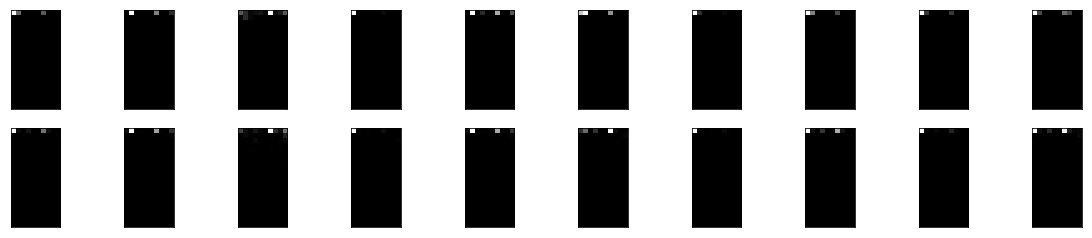

In [19]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

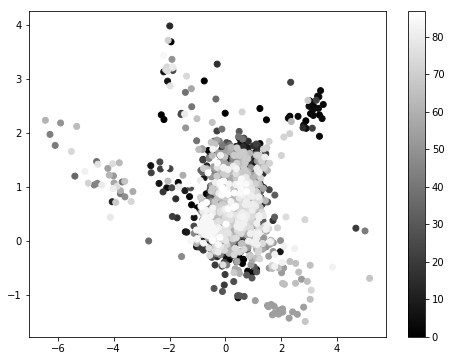

In [20]:
x_test_encoded = encoder.predict(x_train, batch_size=batch_size)
x_test_encoded = np.array(x_test_encoded)
plt.figure(figsize=(8, 6))
plt.scatter(x_test_encoded[2, :, 0], x_test_encoded[2, :, 1], c=y_train)
plt.colorbar()
plt.show()

In [21]:
pair_dist = []
pair_label = []

for i in np.arange(x_test_encoded[2].shape[0]):
    for j in range(i, x_test_encoded[2].shape[0]):
        d = np.sqrt(np.power(x_test_encoded[2, i] - x_test_encoded[2, j], 2).sum())
        pair_dist.append(d)
        
        if y_train[i] == y_train[j]:
            pair_label.append(True)
        else:
            pair_label.append(False)

print roc_auc_score(y_true=pair_label, y_score=pair_dist)

0.32105029081936604


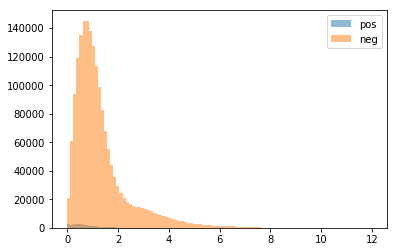

In [22]:
pair_dist = np.array(pair_dist)
pair_label = np.array(pair_label)

bins = np.linspace(pair_dist.min(), pair_dist.max(), 100)

plt.hist(pair_dist[pair_label], bins, alpha=0.5, label='pos')
plt.hist(pair_dist[pair_label == False], bins, alpha=0.5, label='neg')
plt.legend(loc='upper right')
plt.show()

In [23]:
# pair_dist = []
# pair_label = []

# for i in np.arange(x_train.shape[0]):
#     for j in range(i, x_train.shape[0]):
#         d = np.sqrt(np.power(x_train[i] - x_train[j], 2).sum())
#         pair_dist.append(d)
        
#         if y_train[i] == y_train[j]:
#             pair_label.append(True)
#         else:
#             pair_label.append(False)
    
# print roc_auc_score(y_true=pair_label, y_score=pair_dist)

In [24]:
mean = np.mean(x_test_encoded[0], axis=0)
print mean

std = np.std(x_test_encoded[0], axis=0)
print std

[0.2655962  0.72828186]
[1.0150545 0.6490129]


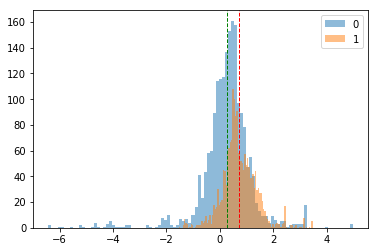

In [25]:
plt.hist(x_test_encoded[0, :, 0], bins=100, alpha=0.5, label='0')
plt.hist(x_test_encoded[0, :, 1], bins=100, alpha=0.5, label='1')

plt.axvline(mean[0], color='green', linestyle='dashed', linewidth=1)
plt.axvline(mean[1], color='red', linestyle='dashed', linewidth=1)

plt.legend()
plt.show()

### Apply Generative Probabilistic Model

In [26]:
N_SINGLETONS = 75
N_PAIRS = 5

In [27]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87])

In [28]:
singletons = np.random.choice(range(y_train.max() + 1), N_SINGLETONS, replace=False)
# pairs = np.random.choice( )
print singletons

[36 31  1 60 18  3  0 21 66 44 82 47 26  2 83 63 15 29 72 42 49 25 76 81
 75 11 13 38 24 73 39 37 71 58 22 78 59 64 57 27 23 52 67 62 65 30 77 55
  8 28 74 85 43 56 87 46 50  9 70 48 32 84 17 19 41  4  6 51 40 35 12 34
 68 33 61]


In [29]:
remaining_idx = []
for i in np.arange(y_train.max() + 1):
    if i not in singletons:
        remaining_idx.append(i)
print remaining_idx

[5, 7, 10, 14, 16, 20, 45, 53, 54, 69, 79, 80, 86]


In [30]:
pairs = np.random.choice(remaining_idx, N_PAIRS, replace=False)
print pairs

[80 20 14 16 69]


In [31]:
vec_list = []
labels = []
GT_POS_PAIRS = []

pid_list = data_dict.keys()

for p in range(len(pairs)):
    pid = pid_list[pairs[p]]
    w1, w2 = np.random.choice(data_dict[pid].keys(), 2)
    app_vec1, app_vec2 = data_dict[pid][w1], data_dict[pid][w2]
    
    vec_list.append(app_vec1 / (app_vec1.max() + 1e-5))
    vec_list.append(app_vec1 / (app_vec2.max() + 1e-5))
    
    labels.append(p + 1)
    labels.append(p + 1)
    GT_POS_PAIRS.append((2* p, 2* p + 1))

for s in singletons:
    pid = pid_list[s]
    w = np.random.choice(data_dict[pid].keys(), 1)
    app_vec = data_dict[pid][w[0]]
    vec_list.append(app_vec / (app_vec.max() + 1e-5))
    labels.append(0)

In [32]:
points = encoder.predict(np.array(vec_list))[2]

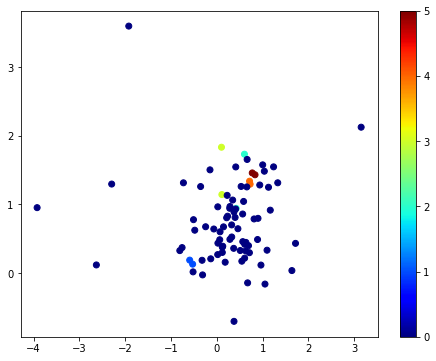

In [41]:
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='jet')
plt.colorbar()
plt.show()

In [35]:
N_DIM = len(points.shape)
test_mean = np.mean(points, axis=0)
print test_mean
sigma = np.std(points)
print sigma

[0.27160522 0.7718385 ]
0.8125519


In [36]:
nu = 0.2

In [37]:
start = time()

LR_arr = []
LR_idx = []

for i in np.arange(points.shape[0]):
    for j in np.arange(i, points.shape[0]):
        midpoint = 0.5 * (points[i] + points[j])
        m = euclidean(midpoint, test_mean)
        d = euclidean(0.5* (points[i] - points[j]), [0,0])
        
        m_prime = m / sigma
        d_prime = d / sigma
        t = nu / sigma
        
        LR = np.power(0.5/t, N_DIM)* np.exp(0.5*(np.power(m_prime,2)+ np.power(d_prime,2)*(2- np.power(t,-2))))
        LR_arr.append(LR)
        
        if (i, j) in GT_POS_PAIRS:
            LR_idx.append(True)
        else:
            LR_idx.append(False)
            
print 'time elapsed: %f s' % (time() - start)

LR_arr = np.array(LR_arr)
LR_idx = np.array(LR_idx)

time elapsed: 0.623668 s


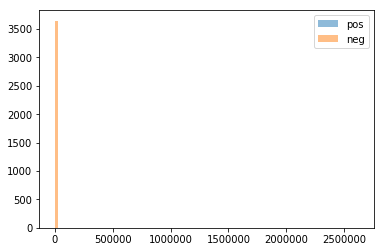

In [38]:
bins = np.linspace(LR_arr.min(), LR_arr.max(), 100)

plt.hist(LR_arr[LR_idx], bins, alpha=0.5, label='pos')
plt.hist(LR_arr[LR_idx == False], bins, alpha=0.5, label='neg')
plt.legend(loc='upper right')
plt.show()

In [39]:
print roc_auc_score(y_true=LR_idx, y_score=LR_arr)

0.8537534246575343
